In [1]:
%matplotlib inline


# EM: TDEM: 1D: Inversion with VTEM waveform

Here we will create and run a TDEM 1D inversion,
with VTEM waveform of which initial condition
is zero, but have some on- and off-time.


SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+02  1.49e+04  0.00e+00  1.49e+04    1.43e+03      0              
   1  1.00e+02  2.04e+03  3.14e+01  5.18e+03    4.67e+03      0              
   2  1.00e+02  1.69e+02  2.38e+01  2.55e+03    1.38e+03      0              
   3  1.00e+02  4.56e+01  2.04e+01  2.08e+03    3.83e+02      0   Skip BFGS  
   4  1.00e+02  5.74e+01  1.95e+01  2.01e+03    1.64e+02      0   Skip BFGS  
   5  1.00e+02  6.66e+01  1.92e+01  1.98e+03    6.64e+01      0   Skip BFGS  
------------------------- STOP! -------------------------


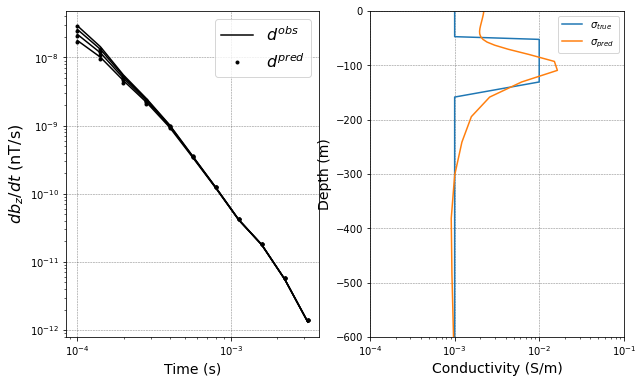

In [2]:
import numpy as np
import discretize
from SimPEG import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics import time_domain as TDEM, utils as EMutils
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver


def run(plotIt=True):

    cs, ncx, ncz, npad = 5.0, 25, 24, 15
    hx = [(cs, ncx), (cs, npad, 1.3)]
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = discretize.CylMesh([hx, 1, hz], "00C")

    active = mesh.vectorCCz < 0.0
    layer = (mesh.vectorCCz < -50.0) & (mesh.vectorCCz >= -150.0)
    actMap = maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nCz)
    mapping = maps.ExpMap(mesh) * maps.SurjectVertical1D(mesh) * actMap
    sig_half = 1e-3
    sig_air = 1e-8
    sig_layer = 1e-2
    sigma = np.ones(mesh.nCz) * sig_air
    sigma[active] = sig_half
    sigma[layer] = sig_layer
    mtrue = np.log(sigma[active])

    x = np.r_[30, 50, 70, 90]
    rxloc = np.c_[x, x * 0.0, np.zeros_like(x)]

    prb = TDEM.Simulation3DMagneticFluxDensity(mesh, sigmaMap=mapping, solver=Solver)
    prb.time_steps = [
        (1e-3, 5),
        (1e-4, 5),
        (5e-5, 10),
        (5e-5, 5),
        (1e-4, 10),
        (5e-4, 10),
    ]
    # Use VTEM waveform
    out = EMutils.VTEMFun(prb.times, 0.00595, 0.006, 100)

    # Forming function handle for waveform using 1D linear interpolation
    wavefun = interp1d(prb.times, out)
    t0 = 0.006
    waveform = TDEM.Src.RawWaveform(offTime=t0, waveFct=wavefun)

    rx = TDEM.Rx.PointMagneticFluxTimeDerivative(
        rxloc, np.logspace(-4, -2.5, 11) + t0, "z"
    )
    src = TDEM.Src.CircularLoop(
        [rx], waveform=waveform, loc=np.array([0.0, 0.0, 0.0]), radius=10.0
    )
    survey = TDEM.Survey([src])
    prb.survey = survey

    # create observed data
    data = prb.make_synthetic_data(mtrue, relative_error=0.02, noise_floor=1e-11)

    dmisfit = data_misfit.L2DataMisfit(simulation=prb, data=data)
    regMesh = discretize.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
    reg = regularization.Simple(regMesh)
    opt = optimization.InexactGaussNewton(maxIter=5, LSshorten=0.5)
    invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
    target = directives.TargetMisfit()
    
    # Create an inversion object
    beta = directives.BetaSchedule(coolingFactor=1.0, coolingRate=2.0)
    betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
    invProb.beta = 1e2
    inv = inversion.BaseInversion(invProb, directiveList=[beta, target])
    m0 = np.log(np.ones(mtrue.size) * sig_half)
    prb.counter = opt.counter = utils.Counter()
    opt.remember("xc")
    mopt = inv.run(m0)

    if plotIt:
        fig, ax = plt.subplots(1, 2, figsize=(10, 6))
        Dobs = data.dobs.reshape((len(rx.times), len(x)))
        Dpred = invProb.dpred.reshape((len(rx.times), len(x)))
        for i in range(len(x)):
            ax[0].loglog(rx.times - t0, -Dobs[:, i].flatten(), "k")
            ax[0].loglog(rx.times - t0, -Dpred[:, i].flatten(), "k.")
            if i == 0:
                ax[0].legend(("$d^{obs}$", "$d^{pred}$"), fontsize=16)
        ax[0].set_xlabel("Time (s)", fontsize=14)
        ax[0].set_ylabel("$db_z / dt$ (nT/s)", fontsize=16)
        ax[0].set_xlabel("Time (s)", fontsize=14)
        ax[0].grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)

        plt.semilogx(sigma[active], mesh.vectorCCz[active])
        plt.semilogx(np.exp(mopt), mesh.vectorCCz[active])
        ax[1].set_ylim(-600, 0)
        ax[1].set_xlim(1e-4, 1e-1)
        ax[1].set_xlabel("Conductivity (S/m)", fontsize=14)
        ax[1].set_ylabel("Depth (m)", fontsize=14)
        ax[1].grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)
        plt.legend(["$\sigma_{true}$", "$\sigma_{pred}$"])


if __name__ == "__main__":
    run()
    plt.show()